In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

In [2]:
true_data = pd.read_csv('True.csv')
fake_data = pd.read_csv('Fake.csv')

In [3]:
print(true_data.shape)
true_data.head()

(21417, 4)


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
print(fake_data.shape)
fake_data.head()

(23481, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
fake_data['label'] = 0
true_data['label'] = 1

Text(0, 0.5, 'Number of News Articles')

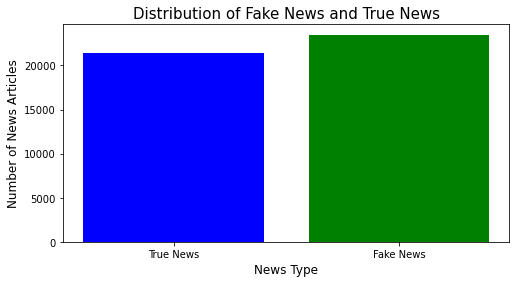

In [6]:
plt.figure(figsize=(8, 4))
plt.bar('True News', len(true_data), color='blue')
plt.bar('Fake News', len(fake_data), color='green')
plt.title('Distribution of Fake News and True News', size=15)
plt.xlabel('News Type', size=12)
plt.ylabel('Number of News Articles', size=12)

In [7]:
fake_data.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [8]:
data = pd.concat([true_data,fake_data],axis=0,ignore_index=True)

In [9]:
print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [10]:
data.tail()

,title,text,subject,date,label
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0
44897,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0


In [11]:
df = data.sample(frac = 1)

In [12]:
df.head(10)

,title,text,subject,date,label
40809,IRRATIONAL GEORGETOWN PROFESSOR Has Month-Long...,A Georgetown University associate professor ha...,left-news,"Dec 28, 2016",0
40271,“GODFATHER OF FAKE NEWS” Brian Williams Calls ...,Watch:good thing we don't have govt-controlled...,left-news,"Apr 7, 2017",0
2185,California sues Trump administration over sanc...,SAN FRANCISCO (Reuters) - California sued the ...,politicsNews,"August 14, 2017",1
11221,Jeb Bush endorsed by former rival Lindsey Grah...,"CHARLESTON, S.C./WASHINGTON (Reuters) - Republ...",politicsNews,"January 15, 2016",1
9982,"Grassley, Garland reprise 1990s judicial confi...",WASHINGTON (Reuters) - Chuck Grassley and Merr...,politicsNews,"April 11, 2016",1
22143,GOP Senator Has Had ENOUGH: Firing Mueller Co...,Senator Lindsey Graham (R-SC) has never been a...,News,"July 27, 2017",0
26752,"WATCH: President Obama Unleashes On Trump, Sa...",During an interview on CBS s Face the Nation S...,News,"July 24, 2016",0
34242,FUNNY! MSNBC ANCHOR ASKS Millennial Women If T...,,politics,"Oct 5, 2016",0
35236,THIRD GRADE BOYS COMPLAIN About 9 Year Old Gir...,Girls aren t the only gender who will suffer e...,politics,"May 26, 2016",0
15571,Lebanon's finances can cope with PM resignatio...,BEIRUT (Reuters) - Lebanon and its financial i...,worldnews,"November 6, 2017",1


In [13]:
def create_corpus(text_data):
   
    corpus1 = []
    for sentence in text_data:
        for word in sentence.split():
            corpus1.append(word)
    return corpus1
            
def top_words(text_corpus1, top_n=25, return_dict=False):
   
    def_dict = defaultdict(int)
    for word in text_corpus1:
        def_dict[word] += 1
    most_common = sorted(def_dict.items(), key=lambda x : x[1], reverse=True)[:top_n]
    if return_dict:
        return most_common, def_dict
    else:    
        return most_common

In [14]:
top_n = 50
text_field = "title"

word_corpus = create_corpus(data[text_field].values)
top_n_words, symptom_dict = top_words(word_corpus, top_n=top_n, return_dict=True)
words, total_word_counts = zip(*top_n_words)

def plot_words(word_list, word_counts, n, text_description, figsize=(15,5)):
    plt.figure(figsize=figsize)
    plt.xticks(rotation=90)
    plt.bar(word_list, word_counts)
    plt.title(f"Top {n} words in News Articles", weight='bold')
    plt.ylabel("Word Count", weight='bold')
    plt.show()

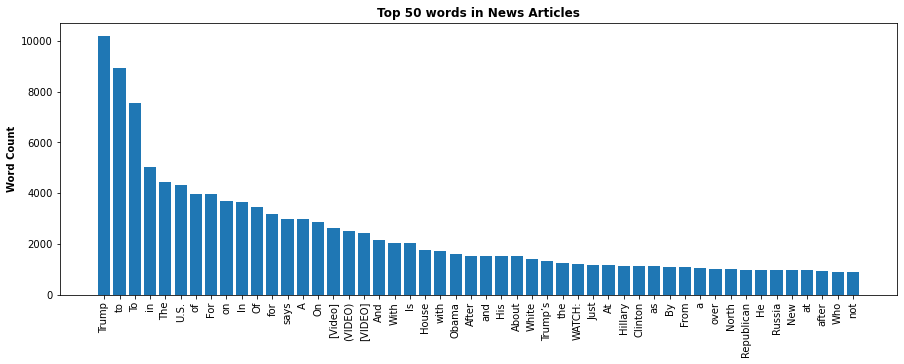

Total unique words in title: 56273


In [15]:
plot_words(words, total_word_counts, 50, " Article Titles")
print(f"Total unique words in {text_field}: {len(symptom_dict)}")

Text(0, 0.5, 'Count')

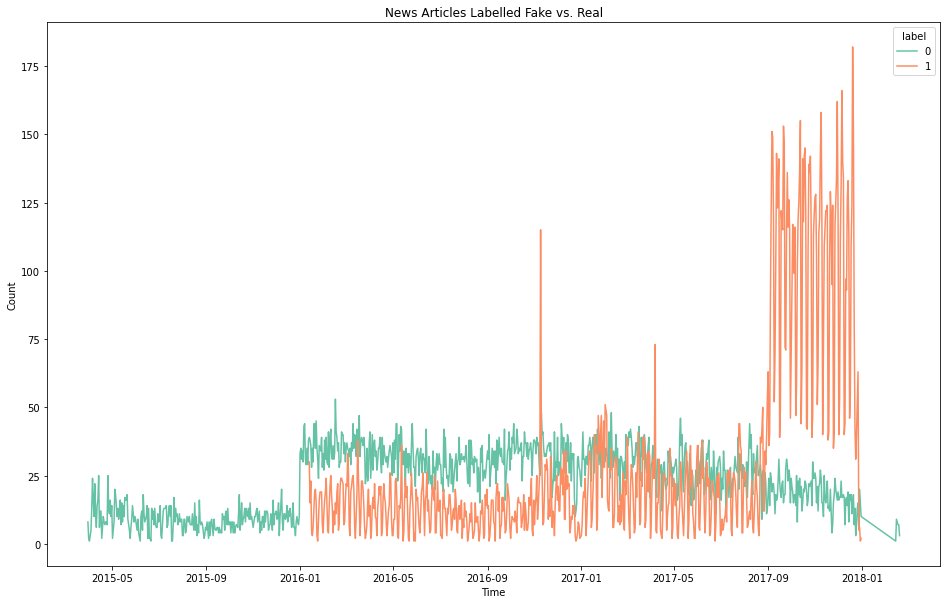

In [16]:
data.date = pd.to_datetime(data.date, errors="coerce")
data_grouped = data[["date", "subject", "label"]].groupby(["date", "label"]).count().reset_index()

fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="date", y="subject", hue="label", data=data_grouped, palette="Set2", ax=ax)
plt.title("News Articles Labelled Fake vs. Real")
plt.xlabel("Time")
plt.ylabel("Count")

In [17]:
x=data.copy()

In [18]:
y = x['label']
x = x.drop('label',axis = 1)

In [19]:
x.isnull().sum()

title       0
text        0
subject     0
date       10
dtype: int64

In [20]:
ps = PorterStemmer()
corpus = []
for i in range(len(x['title'])):
    review = re.sub('[^a-zA-Z]', ' ', x['title'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

In [21]:
corpus

['u budget fight loom republican flip fiscal script',
 'u militari accept transgend recruit monday pentagon',
 'senior u republican senat let mr mueller job',
 'fbi russia probe help australian diplomat tip nyt',
 'trump want postal servic charg much amazon shipment',
 'white hous congress prepar talk spend immigr',
 'trump say russia probe fair timelin unclear nyt',
 'factbox trump twitter dec approv rate amazon',
 'trump twitter dec global warm',
 'alabama offici certifi senat elect jone today despit challeng cnn',
 'jone certifi u senat winner despit moor challeng',
 'new york governor question constitution feder tax overhaul',
 'factbox trump twitter dec vaniti fair hillari clinton',
 'trump twitter dec trump iraq syria',
 'man say deliv manur mnuchin protest new u tax law',
 'virginia offici postpon lotteri draw decid tie statehous elect',
 'u lawmak question businessman trump tower meet sourc',
 'trump twitter dec hillari clinton tax cut bill',
 'u appeal court reject challeng tr

In [22]:
voc_size = 10000
onehot_repr = [one_hot(word,voc_size) for word in corpus]
onehot_repr

[[4675, 6987, 9684, 5522, 6305, 1166, 1503, 4978],
 [4675, 9834, 9763, 6519, 3218, 9110, 3805],
 [9411, 4675, 6305, 7587, 8465, 2225, 5590, 4100],
 [7305, 6536, 5473, 1672, 1811, 8670, 1608, 2678],
 [6392, 8734, 508, 2475, 7475, 2629, 7168, 2756],
 [4813, 9385, 8207, 8059, 4838, 5080, 9015],
 [6392, 8655, 6536, 5473, 7526, 4623, 2748, 2678],
 [4629, 6392, 9078, 5967, 7096, 9199, 7168],
 [6392, 9078, 5967, 7174, 9966],
 [6282, 988, 8019, 7587, 3526, 1265, 7070, 8711, 8795, 1357],
 [1265, 8019, 4675, 7587, 7438, 8711, 3091, 8795],
 [8018, 7704, 2476, 979, 2377, 2532, 2770, 8263],
 [4629, 6392, 9078, 5967, 9500, 7526, 5036, 3170],
 [6392, 9078, 5967, 6392, 6397, 6592],
 [8708, 8655, 4112, 2113, 9066, 9634, 8018, 4675, 2770, 2134],
 [9877, 988, 8766, 241, 2293, 8984, 7704, 7008, 3526],
 [4675, 9982, 979, 4552, 6392, 1807, 4812, 7158],
 [6392, 9078, 5967, 5036, 3170, 2770, 3714, 2211],
 [4675, 2396, 8009, 8993, 8795, 6392, 6127, 6450, 9824],
 [7471, 5032, 9066, 7766, 4157, 8169, 4765, 3324,

In [23]:
sentlen = 20
embedding_doc = pad_sequences(onehot_repr,padding = 'pre',maxlen=sentlen)
embedding_doc

array([[   0,    0,    0, ..., 1166, 1503, 4978],
       [   0,    0,    0, ..., 3218, 9110, 3805],
       [   0,    0,    0, ..., 2225, 5590, 4100],
       ...,
       [   0,    0,    0, ...,  847, 4389, 6592],
       [   0,    0,    0, ..., 7909, 3191,  889],
       [   0,    0,    0, ..., 4739, 2193, 7828]])

In [24]:
embedding_feature = 60
model = Sequential()
model.add(Embedding(voc_size,embedding_feature,input_length=sentlen))
model.add(LSTM(64,return_sequences=True))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(LSTM(32))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(1,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [25]:
x_final = np.array(embedding_doc)

In [26]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_final,y,test_size=0.6,random_state=1)

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

Epoch 1/10
141/141 [==============================] - 9s 64ms/step - loss: 0.5408 - accuracy: 0.8404 - val_loss: 0.6923 - val_accuracy: 0.5218
Epoch 2/10
141/141 [==============================] - 8s 57ms/step - loss: 0.4011 - accuracy: 0.9326 - val_loss: 0.6696 - val_accuracy: 0.5968
Epoch 3/10
141/141 [==============================] - 8s 56ms/step - loss: 0.3503 - accuracy: 0.9475 - val_loss: 0.4816 - val_accuracy: 0.8336
Epoch 4/10
141/141 [==============================] - 8s 58ms/step - loss: 0.3152 - accuracy: 0.9555 - val_loss: 0.3936 - val_accuracy: 0.9201
Epoch 5/10
141/141 [==============================] - 8s 56ms/step - loss: 0.2851 - accuracy: 0.9632 - val_loss: 0.3517 - val_accuracy: 0.9098
Epoch 6/10
141/141 [==============================] - 8s 57ms/step - loss: 0.2506 - accuracy: 0.9718 - val_loss: 0.3623 - val_accuracy: 0.9122
Epoch 7/10
141/141 [==============================] - 8s 56ms/step - loss: 0.2299 - accuracy: 0.9736 - val_loss: 0.3414 - val_accuracy: 0.9022

<AxesSubplot:title={'center':'Accuracy'}>

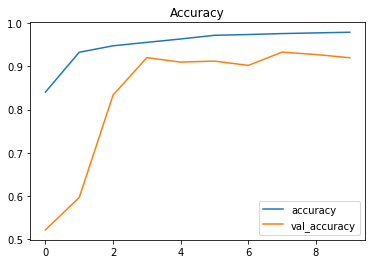

In [28]:
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=128,callbacks=[early_stopping])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [29]:
result = model.evaluate(x_test, y_test)

loss = result[0]
accuracy1 = result[1]
print(f"[+] Accuracy: {accuracy1*100:.2f}%")


842/842 [==============================] - 5s 6ms/step - loss: 0.3878 - accuracy: 0.9199
[+] Accuracy: 91.99%


In [30]:
pred = model.predict(x_test)

prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
print('Accuracy on testing set:', accuracy_score(prediction, y_test))
print('Precision on testing set:', precision_score(prediction, y_test))
print('Recall on testing set:', recall_score(prediction, y_test))

Accuracy on testing set: 0.9198930917999926
Precision on testing set: 0.9248295102293862
Recall on testing set: 0.9094650205761317


In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
cm

array([[12847,  1188],
       [  970, 11934]], dtype=int64)

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

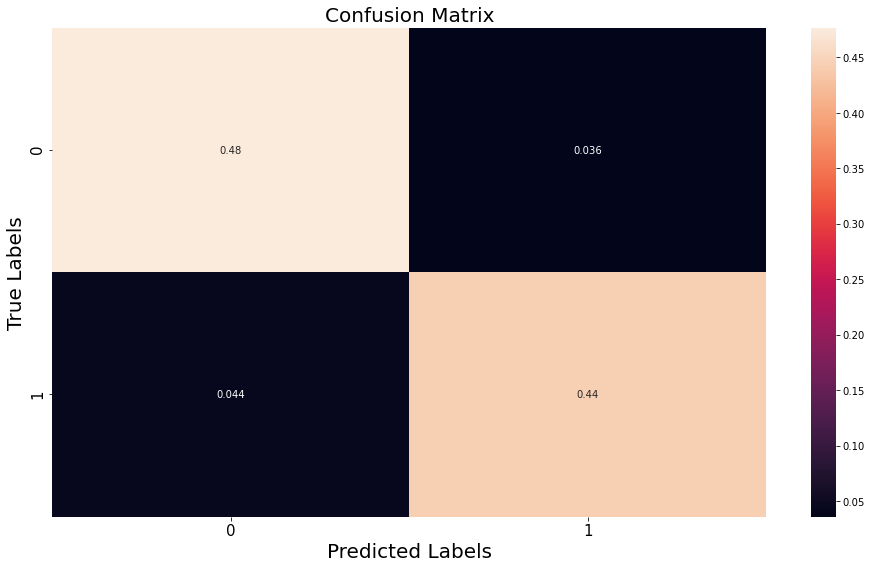

In [33]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt  
from sklearn.metrics import ConfusionMatrixDisplay
matrix = confusion_matrix(prediction, y_test,normalize="all")

plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

In [34]:
data1 = data.sample(frac = 1)

In [35]:
data1.title = data1.title.str.lower()
data1.text = data1.text.str.lower()
data1 = data1.drop(columns = ['subject','date'])

In [36]:
data1.text = data1.title + ' ' + data1.text

In [37]:
data1 = data1.drop(columns = ['title'])

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [39]:
x_train,x_test,y_train,y_test = train_test_split(data1['text'], data1.label, test_size=0.6, random_state=2020)

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LinearSVC())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy by svc prediction: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy by svc prediction: 99.34%


In [40]:
print(confusion_matrix(y_test, prediction))

[[13929    96]
 [   83 12831]]


AttributeError: 'Axes' object has no attribute 'line'

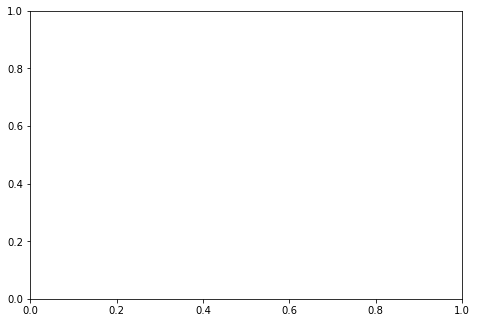

In [42]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['LSTM', 'SVM']
accuracies = [94,99]
ax.line(models,accuracies)
plt.show()